## Setting Up

### Installing Dependencies

In [1]:
%pip install openai pydantic instructor pandas matplotlib networkx python-dotenv jinja2
from IPython.display import clear_output ; clear_output()

### Loading Azure Open AI configuration

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
GPT_4_O_MODEL_NAME = os.getenv("GPT_4_O_MODEL_NAME", default="gpt-4o")

from openai import AzureOpenAI

aoai = AzureOpenAI(
    api_version="2024-05-01-preview",
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
)

## Using Structured Input/Output with OpenAI

In [3]:
import instructor
from pydantic import BaseModel, Field
from typing import List
from enum import Enum
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


client = instructor.from_openai(aoai)

def llm(response_model: BaseModel = BaseModel, system: str = None, user: str = None, temperature: float = 0.0, max_tokens: int = 1000):
    messages = []
    if system:
        messages.append({"role": "system", "content": system})
    if user:
        messages.append({"role": "user", "content": user})
    result = client.chat.completions.create(
        model=GPT_4_O_MODEL_NAME,
        response_model=response_model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return result

def print_schema(model: BaseModel):
    print(json.dumps(model.model_json_schema(), indent=2))

def print_result(result: BaseModel):
    print(result.model_dump_json(indent=2))

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)
pd.DataFrame._repr_html_ = lambda df: df.style.set_properties(**{'text-align': 'left'})._repr_html_()

def visualize_graph(graph):
    G = nx.DiGraph()
    for node in graph.nodes:
        G.add_node(node.id, label=node.label, color=node.color)
    for edge in graph.edges:
        G.add_edge(edge.source, edge.target, label=edge.label, color=edge.color)
    pos = nx.planar_layout(G)
    node_colors = [node[1]['color'] for node in G.nodes(data=True)]
    edge_colors = [edge[2]['color'] for edge in G.edges(data=True)]
    labels = {node[0]: node[1]['label'] for node in G.nodes(data=True)}
    plt.figure(figsize=(7, 5))
    nx.draw(G, pos, labels=labels, with_labels=True, node_color=node_colors, edge_color=edge_colors, font_size=8)
    plt.title("Knowledge Graph")
    plt.show()

def print_tree(data, indent=0):
    if isinstance(data, dict):
        for key, value in data.items():
            print('   ' * indent + key.upper() + ':')
            print_tree(value, indent + 1)
    elif isinstance(data, list):
        for item in data:
            print_tree(item, indent)
    else:
        print('   ' * indent + str(data))

## Working with Text

### Translation and Normalization

In [4]:
class TranslatedString(BaseModel):
    input_language: str = Field(..., description="The language of the original text, as 2-letter language code.")
    translation: str

translation = llm(
    TranslatedString,
    "Detect the language of the original text and translate it into English.",
    "Sprachkenntnisse sind ein wichtiger Bestandteil der Kommunikation.",
)

print_result(translation)

{
  "input_language": "de",
  "translation": "Language skills are an important part of communication."
}


In [5]:
class TargetLanguage(str, Enum):
    de = "de"
    fr = "fr"
    it = "it"
    es = "es"
    he = "he"

class Translation(BaseModel):
    language: TargetLanguage = Field(..., description=f"The language of the translated text, as 2-letter language code.")
    translation: str

class Translations(BaseModel):
    translations: List[Translation]

translations = llm(
    Translations,
    f"Translate the user-provided text into the following languages: {json.dumps([language.value for language in TargetLanguage])}",
    "Large Language Models are a powerful tool for natural language processing.",
    temperature=0.7,
)

pd.DataFrame(translations.dict()["translations"])

,language,translation
0,TargetLanguage.de,Große Sprachmodelle sind ein leistungsstarkes Werkzeug für die Verarbeitung natürlicher Sprache.
1,TargetLanguage.fr,Les grands modèles de langage sont un outil puissant pour le traitement du langage naturel.
2,TargetLanguage.it,I modelli di linguaggio di grandi dimensioni sono uno strumento potente per l'elaborazione del linguaggio naturale.
3,TargetLanguage.es,Los modelos de lenguaje grandes son una herramienta poderosa para el procesamiento del lenguaje natural.
4,TargetLanguage.he,מודלים גדולים של שפה הם כלי עוצמתי לעיבוד שפה טבעית.


In [6]:
class TextStyle(str, Enum):
    formal = "formal"
    informal = "informal"
    casual = "casual"
    academic = "academic"
    professional = "professional"
    business = "business"

class NormalizedText(BaseModel):
    style: TextStyle = Field(..., description=("The style of the text normalization."))
    text: str

class NormalizedTexts(BaseModel):
    normalized_texts: List[NormalizedText]

normalizations = llm(
    NormalizedTexts,
    f"Normalize the user-provided text into the following styles: {json.dumps([style.value for style in TextStyle])}",
    "Large Language Models are a powerful tool for natural language processing.",
    temperature=0.7,
)

pd.DataFrame(normalizations.dict()["normalized_texts"])

,style,text
0,TextStyle.formal,Large Language Models are a powerful tool for natural language processing.
1,TextStyle.informal,Big language models are great for NLP.
2,TextStyle.casual,Big language models are super useful for natural language stuff.
3,TextStyle.academic,Large Language Models constitute a significant advancement in the field of natural language processing.
4,TextStyle.professional,Large Language Models represent a substantial innovation in natural language processing.
5,TextStyle.business,Large Language Models offer a significant competitive edge in natural language processing applications.


### Unstructured Data

In [7]:
class AddressInfo(BaseModel):
    first_name: str
    last_name: str
    street: str
    house_number: str
    postal_code: str
    city: str
    state: str
    country: str

address_info = llm(
    AddressInfo,
    "Eleanor Berger lives in Switzerland, in the canton of Zürich. Her home is at Freilagerstrasse 97, 8047 Zürich."
)

print_result(address_info)

{
  "first_name": "Eleanor",
  "last_name": "Berger",
  "street": "Freilagerstrasse",
  "house_number": "97",
  "postal_code": "8047",
  "city": "Zürich",
  "state": "Zürich",
  "country": "Switzerland"
}


In [8]:
input_text = (
  "During my recent travels, I had the pleasure of visiting several fascinating locations. "
  "My journey began at the office of Dr. Elena Martinez, 142B Elm Street, San Francisco, "
  "CA 94107, USA. Her office, nestled in the bustling heart of the city, was a hub of "
  "innovation and creativity. Next, I made my way to the historic residence of Mr. Hans "
  "Gruber located at 3. Stock, Goethestrasse 22, 8001 Zürich, Switzerland. The old building, "
  "with its classic Swiss architecture, stood as a testament to the city’s rich cultural "
  "heritage. My adventure continued at the tranquil countryside home of Satoshi Nakamoto, "
  "2-15-5, Sakura-cho, Musashino-shi, Tokyo-to 180-0003, Japan. Their home was surrounded by "
  "beautiful cherry blossoms, creating a picturesque scene straight out of a postcard. In "
  "Europe, I visited the charming villa of Mme. Catherine Dubois, 15 Rue de la République, "
  "69002 Lyon, France. The cobblestone streets and historic buildings of Lyon provided a "
  "perfect backdrop to her elegant home. Finally, my journey concluded at the modern apartment "
  "of Mr. David Johnson, Apt 7B, 34 Queen Street, Toronto, ON M5H 2Y4, Canada. The sleek "
  "design of the apartment building mirrored the contemporary vibe of the city itself."
  )

class Addresses(BaseModel):
    addresses: List[AddressInfo]

addresses_in_text = llm(
    Addresses,
    "Return all the addresses in the user-provided text.",
    input_text,
)

pd.DataFrame(addresses_in_text.dict()["addresses"])

,first_name,last_name,street,house_number,postal_code,city,state,country
0,Elena,Martinez,Elm Street,142B,94107,San Francisco,CA,USA
1,Hans,Gruber,Goethestrasse,22,8001,Zürich,,Switzerland
2,Satoshi,Nakamoto,Sakura-cho,2-15-5,180-0003,Musashino-shi,Tokyo-to,Japan
3,Catherine,Dubois,Rue de la République,15,69002,Lyon,,France
4,David,Johnson,Queen Street,34,M5H 2Y4,Toronto,ON,Canada


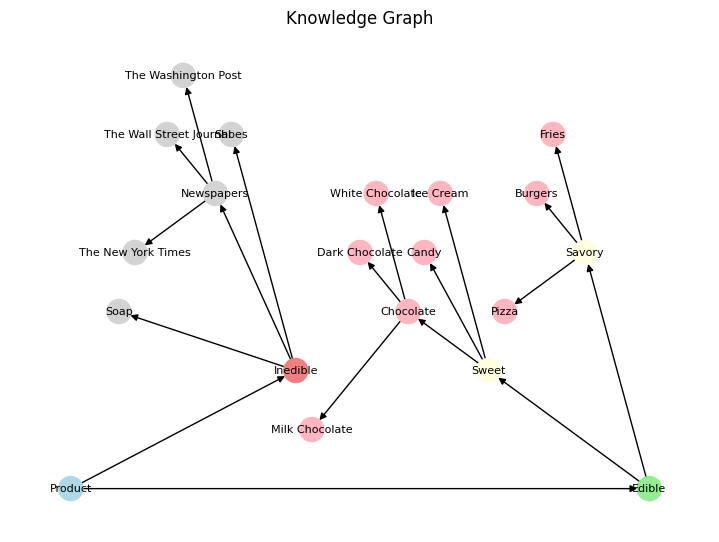

In [9]:
class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

class KnowledgeGraph(BaseModel):
    nodes: List[Node] = Field(..., default_factory=list)
    edges: List[Edge] = Field(..., default_factory=list)

input_text = (
    "Some products are edible and others are inedible. Soap, newspapers, and shoes, for example, "
    "are inedible. Of the products that are edible, some are sweet and others are savory. "
    "Chocolate, candy, and ice cream are sweet, while pizza, burgers, and fries are savory. "
    "Chocolate comes in different forms, such as milk chocolate, dark chocolate, and white chocolate. "
    "The New York Times, The Wall Street Journal, and The Washington Post are newspapers."
)

knowledge_graph = llm(
    KnowledgeGraph,
    "Help the user understand the provided text by generating a knowledge graph.",
    input_text,
)

visualize_graph(knowledge_graph)


In [10]:
class NounPhrase(BaseModel):
    det: str
    adj: List[str]
    noun: str

class PrepPhrase(BaseModel):
    prep: str
    noun: NounPhrase

class VerbPhrase(BaseModel):
    noun: NounPhrase
    verb: str
    prep: PrepPhrase

grammar_tree = llm(
    VerbPhrase,
    "Parse the user-provided sentence into a simple grammar tree.",
    "the quick brown fox jumps over the lazy dog",
)

print_tree(grammar_tree.dict())


NOUN:
   DET:
      the
   ADJ:
      quick
      brown
   NOUN:
      fox
VERB:
   jumps
PREP:
   PREP:
      over
   NOUN:
      DET:
         the
      ADJ:
         lazy
      NOUN:
         dog


## Decision Making

### Sentiment Analysis

In [11]:
example_texts = [
    "I am very happy with the service provided by the company.",
    "The food was terrible and the service was slow.",
    "The movie was okay.",
    "The weather is perfect for a day at the beach.",
    "I am mostly satisfied with the product, but there are a few issues.",
    "The experience was note quite what I have expected.",
    "Butterflies are often colourful, and they can fly.",
]

class Sentiment(str, Enum):
    positive = "positive"
    negative = "negative"
    neutral = "neutral"

class SentimentAnalysis(BaseModel):
    sentiment: Sentiment
    confidence: float

results = []
for example_text in example_texts:
    sentiment_analysis = llm(
        SentimentAnalysis,
        "Analyze the sentiment of the user-provided text.",
        example_text,
    )
    results.append({
        "text": example_text,
        "sentiment": sentiment_analysis.sentiment.value,
        "confidence": f"{sentiment_analysis.confidence * 100:.0f}%",
    })

pd.DataFrame(results)

,text,sentiment,confidence
0,I am very happy with the service provided by the company.,positive,95%
1,The food was terrible and the service was slow.,negative,95%
2,The movie was okay.,neutral,80%
3,The weather is perfect for a day at the beach.,positive,95%
4,"I am mostly satisfied with the product, but there are a few issues.",neutral,70%
5,The experience was note quite what I have expected.,negative,80%
6,"Butterflies are often colourful, and they can fly.",neutral,95%


### Classification

In [12]:
items = [
    {"title": "The Great Gatsby", "subtitle": "A novel by F. Scott Fitzgerald"},
    {"title": "The Theory of Relativity", "subtitle": "A scientific theory by Albert Einstein"},
    {"title": "The Technology and Culture of Ancient Rome", "subtitle": "A cross-disciplinary study of ancient Rome"},
    {"title": "Football on Television", "subtitle": "The technology and cultural impact of televising football games"},
    {"title": "The Philosophy of Taylor Swift", "subtitle": "A philosophical analysis of the music and lyrics of Taylor Swift"},
    {"title": "The Spanish Language in popular music", "subtitle": "A review of the use of the Spanish language in popular music"},
    {"title": "The Impact of Artificial Intelligence on Healthcare", "subtitle": "Exploring the role of AI in revolutionizing healthcare"},
    {"title": "The History of Jazz Music", "subtitle": "Tracing the origins and evolution of jazz music"},
    {"title": "The Rise of E-commerce in the Digital Age", "subtitle": "Examining the growth and impact of online shopping"},
    {"title": "The Art of Photography", "subtitle": "Exploring the creative and technical aspects of photography"},
    {"title": "The Psychology of Decision Making", "subtitle": "Understanding the cognitive processes behind decision making"},
    {"title": "The Role of Women in STEM Fields", "subtitle": "Highlighting the contributions of women in science, technology, engineering, and mathematics"},
    {"title": "The Cultural Significance of Tattoos", "subtitle": "Exploring the history and symbolism of tattoos in different cultures"},
]


class Tag(str, Enum):
    literature = "literature"
    science = "science"
    history = "history"
    technology = "technology"
    art = "art"
    music = "music"
    sports = "sports"
    philosophy = "philosophy"
    language = "language"
    feminism = "feminism"
    health = "health"
    media = "media"
    physics = "physics"
    culture = "culture"
    psychology = "psychology"
    artificial_intelligence = "artificial-intelligence"


class TaggableItem(BaseModel):
    title: str
    subtitle: str
    tags: List[Tag]


class TaggableItems(BaseModel):
    items: List[TaggableItem]


tagged_items = llm(
    TaggableItems,
    f"Tag the following items with the appropriate tags. Options: {json.dumps([tag.value for tag in Tag])}",
    json.dumps(items),
)

pd.DataFrame([
  {"title": item.title, "subtitle": item.subtitle, "tags": ' '.join(item.tags)}
  for item in tagged_items.items
])

,title,subtitle,tags
0,The Great Gatsby,A novel by F. Scott Fitzgerald,literature
1,The Theory of Relativity,A scientific theory by Albert Einstein,science physics
2,The Technology and Culture of Ancient Rome,A cross-disciplinary study of ancient Rome,technology culture history
3,Football on Television,The technology and cultural impact of televising football games,technology culture sports media
4,The Philosophy of Taylor Swift,A philosophical analysis of the music and lyrics of Taylor Swift,philosophy music
5,The Spanish Language in popular music,A review of the use of the Spanish language in popular music,language music culture
6,The Impact of Artificial Intelligence on Healthcare,Exploring the role of AI in revolutionizing healthcare,artificial-intelligence health technology
7,The History of Jazz Music,Tracing the origins and evolution of jazz music,history music culture
8,The Rise of E-commerce in the Digital Age,Examining the growth and impact of online shopping,technology culture
9,The Art of Photography,Exploring the creative and technical aspects of photography,art technology


In [13]:
class TaggableItemsCluster(BaseModel):
    title: str
    items: List[TaggableItem]

class TaggableItemsClusters(BaseModel):
    clusters: List[TaggableItemsCluster]

num_clusters = 5

tagged_items_clusters = llm(
    TaggableItemsClusters,
    f"Cluster the following items based on their tags and content. Create exactly {num_clusters} clusters.",
    json.dumps(tagged_items.dict()["items"]),
)

clusters = []
for cluster in tagged_items_clusters.clusters:
  for item in cluster.items:
    clusters.append({"cluster": cluster.title, "title": item.title, "subtitle": item.subtitle, "tags": ' '.join(item.tags)})
pd.DataFrame(clusters)

KeyboardInterrupt: 

## Synthetic Data Generation

In [ ]:
class SyntheticSentiment(BaseModel):
    sentiment: str = Field(..., description="A review about food.")
    rating: int

sentiment = llm(
    SyntheticSentiment,
    "Generate food review with sentiments within a spectrum of sentiments, with rating between 1 and 5.",
    temperature= 0.5
)

print_result(sentiment)

{
  "sentiment": "The pizza was absolutely fantastic! The crust was perfectly crispy, and the cheese melted just right. The toppings were fresh and flavorful. I couldn't have asked for a better meal.",
  "rating": 5
}


In [ ]:
class Rating(str, Enum):
    poor = "*"
    average = "**"
    good = "***"
    great = "****"
    outstanding = "*****"

class SyntheticSentiment(BaseModel):
    sentiment: str = Field(..., description="A generated review about food.")
    rating: str = Field(...,description="rating of food review between 1 and 5")

class SyntheticSentiments(BaseModel):
    sentiments: List[SyntheticSentiment]

n = 10

sentiments = llm(
    SyntheticSentiments,
    f"Generate {n} food review with sentiments within a spectrum of sentiments in sorted order from most negative to positive, with rating. : {json.dumps([rating for rating in Rating])}",
    temperature=0.7,
)

pd.DataFrame(sentiments.dict()["sentiments"])

,sentiment,rating
0,"The burger was cold, soggy, and completely tasteless. A total waste of money.",*
1,The pasta was overcooked and the sauce was bland. Not worth the price at all.,*
2,The salad was wilted and the dressing was too acidic. Very disappointing.,**
3,The sushi rolls were mediocre at best. The rice was dry and the fish wasn't fresh.,**
4,The pizza was just okay. The crust was a bit too chewy and the toppings were sparse.,***
5,"The sandwich was decent, but nothing special. The bread was a bit stale.",***
6,"The steak was cooked to perfection, but the sides were underwhelming.",****
7,The dessert was delightful. Rich flavors and beautifully presented.,****
8,"The seafood platter was fantastic. Fresh, flavorful, and well-seasoned.",*****
9,"The gourmet burger was absolutely amazing. Juicy, flavorful, and perfectly cooked.",*****


## Planning and Tool-Use

In [21]:
class Action(str, Enum):
  WAKE_UP = "Wake up"
  TURN_OFF_ALARM = "Turn off the alarm"
  STRETCH = "Stretch"
  GET_OUT_OF_BED = "Get out of bed"
  USE_BATHROOM = "Use the bathroom"
  CHECK_FOR_MOVIE_SNACKS = "Check for movie snacks"
  WASH_FACE_EVENING = "Wash face in the evening"
  CHANGE_INTO_PYJAMAS = "Change into pyjamas"
  SET_ALARM_FOR_NEXT_DAY = "Set alarm for the next day"
  CHECK_PHONE_FOR_MESSAGES = "Check phone for messages"
  TURN_OFF_LIGHTS = "Turn off lights"
  WALK_OR_DRIVE_TO_MOVIE_THEATRE = "Walk or drive to the movie theatre"
  USE_BATHROOM_EVENING = "Use the bathroom in the evening"
  DRY_OFF_WITH_TOWEL = "Dry off with a towel"
  BRUSH_TEETH = "Brush teeth"
  WASH_FACE = "Wash face"
  SHOWER = "Take a shower"
  GRAB_WALLET_PURSE = "Grab wallet or purse"
  MAKE_SURE_PHONE_IS_CHARGED = "Make sure phone is charged"
  CALL_A_TAXI_ARRANGE_TRANSPORTATION = "Call a taxi or arrange transportation"
  MEET_FRIENDS_AT_DESIGNATED_PLACE = "Meet friends at designated place"
  LEAVE_THE_HOUSE = "Leave the house"
  PLAN_TO_BUY_AT_THEATRE = "Plan to buy tickets at the theatre"
  DECIDE_ON_MEETING_PLACE_AND_TIME = "Decide on meeting place and time"
  GET_DRESSED = "Get dressed"
  APPLY_DEODORANT = "Apply deodorant"
  COMB_BRUSH_HAIR = "Comb or brush hair"
  STYLE_HAIR = "Style hair"
  SHAVE = "Shave"
  PUT_ON_CLOTHES = "Put on clothes"
  APPLY_MAKEUP = "Apply makeup"
  PREPARE_BREAKFAST = "Prepare breakfast"
  EAT_BREAKFAST = "Eat breakfast"
  MAKE_COFFEE_TEA = "Make coffee or tea"
  CHECK_PHONE_FOR_MESSAGES_EMAILS = "Check phone for messages or emails"
  PACK_LUNCH = "Pack lunch"
  GATHER_WORK_MATERIALS = "Gather work materials"
  PUT_ON_SHOES = "Put on shoes"
  GRAB_KEYS = "Grab keys"
  PURCHASE_TICKETS_AT_THEATRE = "Purchase tickets at the theatre"
  LOCK_THE_DOOR = "Lock the door"
  FINISH_DINNER = "Finish dinner"
  CLEAN_UP_DINNER_DISHES = "Clean up dinner dishes"
  WATCH_TV_READ_BOOK = "Watch TV or read a book"
  BRUSH_TEETH_EVENING = "Brush teeth in the evening"
  GET_INTO_BED = "Get into bed"
  MEDITATE_RELAX = "Meditate or relax"
  WRITE_IN_JOURNAL = "Write in journal"
  LISTEN_TO_CALMING_MUSIC = "Listen to calming music"
  TURN_OFF_ELECTRONIC_DEVICES = "Turn off electronic devices"
  ADJUST_PILLOWS_AND_BLANKETS = "Adjust pillows and blankets"
  READ_BOOK = "Read a book"
  CLOSE_EYES_TRY_TO_SLEEP = "Close eyes and try to sleep"
  DECIDE_ON_MOVIE_TO_WATCH = "Decide on a movie to watch"
  CHECK_MOVIE_TIMES_ONLINE = "Check movie times online"
  PURCHASE_TICKETS_ONLINE = "Purchase tickets online"
  BUY_SNACKS_AT_CONCESSION_STAND = "Buy snacks at the concession stand"
  FIND_CORRECT_THEATRE_SCREEN = "Find the correct theatre screen"
  FIND_SEATS = "Find seats"
  WATCH_THE_MOVIE = "Watch the movie"
  DISCUSS_MOVIE_WITH_FRIENDS = "Discuss the movie with friends"
  SAY_GOODBYE_TO_FRIENDS = "Say goodbye to friends"
  RETURN_HOME = "Return home"

class ActionSequence(BaseModel):
  actions: List[Action]

activities = [
  "Waking up and going to work",
  "Winding down and going to sleep",
  "Going to see a movie with friends",
]

for activity in activities:
  action_sequence = llm(
      ActionSequence,
      "Generate a sequence of actions for the user-provided activity.",
      activity,
  )
  print(f"Activity: {activity}")
  for index, action in enumerate(action_sequence.actions, start=1):
    print(f"{index}. {action.value}")
  print()

Activity: Waking up and going to work
1. Wake up
2. Turn off the alarm
3. Stretch
4. Get out of bed
5. Use the bathroom
6. Wash face
7. Brush teeth
8. Get dressed
9. Apply deodorant
10. Comb or brush hair
11. Prepare breakfast
12. Eat breakfast
13. Make coffee or tea
14. Check phone for messages or emails
15. Pack lunch
16. Gather work materials
17. Put on shoes
18. Grab keys
19. Make sure phone is charged
20. Leave the house
21. Lock the door

Activity: Winding down and going to sleep
1. Finish dinner
2. Clean up dinner dishes
3. Watch TV or read a book
4. Brush teeth in the evening
5. Wash face in the evening
6. Use the bathroom in the evening
7. Change into pyjamas
8. Set alarm for the next day
9. Turn off electronic devices
10. Get into bed
11. Adjust pillows and blankets
12. Listen to calming music
13. Close eyes and try to sleep

Activity: Going to see a movie with friends
1. Decide on a movie to watch
2. Check movie times online
3. Decide on meeting place and time
4. Call a taxi

In [ ]:
class TicTacToeMove(BaseModel):
  row: int
  col: int

class TicTacToeWinner(str, Enum):
  X = "X"
  O = "O"
  Tie = "Tie"
  Ongoing = "Ongoing"

class TicTacToeStatus(BaseModel):
  winner: TicTacToeWinner

class TicTacToeBoard:
  def __init__(self):
    self.board = [[' ' for _ in range(3)] for _ in range(3)]
  
  def dumps_board(self):
    return '\n-----\n'.join(['|'.join(row) for row in self.board]) + '\n'

  def print_board(self):
    print(self.dumps_board())
  
  def make_move(self, role, move: TicTacToeMove):
    self.board[move.row][move.col] = role
  
  def check_status(self) -> TicTacToeWinner:
    return llm(
        TicTacToeStatus,
        ("Check the status and whether there is a winner in this game of Tic-Tac-Toe. " +
         "The options are: X - X won, O - O won, " +
         "Tie - there are no more possible moves and it's a tie, " +
         "Ongoing - there are still empty slots on the board."),
        self.dumps_board(),
    ).winner

class TicTacToePlayer:
  def __init__(self, role):
    self.role = role

  def turn(self, board):
    move = llm(
        TicTacToeMove,
        ("You are a Tic-Tac-Toe Player, always following the optimal strategy. " +
         f"Your role is: {self.role}. It's your turn. " +
         "Look at the board and announce your move."),
        board.dumps_board(),
    )
    board.make_move(self.role, move)
    board.print_board()

board = TicTacToeBoard()
player_x = TicTacToePlayer('X')
player_o = TicTacToePlayer('O')

next_player = player_x
while board.check_status() == TicTacToeWinner.Ongoing:
  next_player.turn(board)
  next_player = player_x if next_player == player_o else player_o

print(f"Game Over! Winner: {board.check_status()}")

X| | 
-----
 | | 
-----
 | | 

X|O| 
-----
 | | 
-----
 | | 

X|O|X
-----
 | | 
-----
 | | 

X|O|X
-----
 |O| 
-----
 | | 

X|O|X
-----
 |O| 
-----
 | |X

X|O|X
-----
 |O| 
-----
O| |X

X|O|X
-----
X|O| 
-----
O| |X

X|O|X
-----
X|O|O
-----
O| |X

X|O|X
-----
X|O|O
-----
O|X|X

Game Over! Winner: Tie
